In [ ]:
! git clone https://github.com/UCMerced-ML/LC-model-compression

In [ ]:
! pip3 install -e ./LC-model-compression

## IMPORTANT!
At this point you need to restart the runtime by doing "Runtime => Restart Runtime"

In [1]:
import lc
from lc.torch import ParameterTorch as Param, AsVector, AsIs
from lc.compression_types import ConstraintL0Pruning, LowRank, RankSelection, AdaptiveQuantization
from lc.models.torch import lenet300_classic, lenet300_modern_drop, lenet300_modern
# from utils import compute_acc_loss

import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter
torch.set_num_threads(4)

In [2]:
def compute_acc_loss(forward_func, data_loader):
    correct_cnt, ave_loss = 0, 0
    for batch_idx, (x, target) in enumerate(data_loader):
        with torch.no_grad():
            target = target.cuda()
            score, loss = forward_func(x.cuda(), target)
            _, pred_label = torch.max(score.data, 1)
            correct_cnt += (pred_label == target.data).sum().item()
            ave_loss += loss.data.item() * len(x)
    accuracy = correct_cnt * 1.0 / len(data_loader.dataset)
    ave_loss /= len(data_loader.dataset)
    return accuracy, ave_loss

## Data
We use the MNIST dataset for this demo. The dataset contains 28x28 grayscale images with digits from 0 to 9. The images are normalized to have grayscale value 0 to 1 and then mean is subtracted.

In [4]:
def extractMNIST(data, set1, set2, set3, set4): 
    xTrain = np.array(data[set1])
    yTrain = np.array(data[set2])
    xTest = np.array(data[set3])
    yTest = np.array(data[set4])
    return xTrain, yTrain, xTest, yTest

# concats the digit subsets into a single X input and y vector
def combineDigitData(d1fea, d2fea, d1gnd, d2gnd):
    # print(d2fea.shape)
    if d1fea.shape[0] == 0:
        return d2fea, d2gnd
        
    X = np.concatenate((d1fea, d2fea))
    y = np.concatenate([d1gnd, d2gnd])
    return X, y

# get indexes of specified digit in MNISTmini
def getDigitRange(gnd, digit):      
    digit_range = np.where(np.logical_and(gnd > digit-1, gnd < digit+1))
    digit_idx = digit_range[0]
    return digit_idx

# extract features based on indexes
def getDigitFea(digit, fea, gnd):   
    digit_range = getDigitRange(gnd, digit)
    return fea[digit_range]

# extract ground truth based on indexes
def getDigitGnd(digit, gnd):        
    digit_range = getDigitRange(gnd, digit)
    return gnd[digit_range].flatten()

def datasetByDigitList(digit_list, x, y):
    newX = np.array([])
    newY = np.array([])

    for digit in digit_list:
        fea = getDigitFea(digit, x, y)
        gnd = getDigitGnd(digit, y)
        newX, newY = combineDigitData(newX, fea, newY, gnd)

    return newX, newY

In [7]:
from scipy.io import loadmat

# Load MNIST.mat
! wget -P /content/data --no-check-certificate https://faculty.ucmerced.edu/mcarreira-perpinan/teaching/CSE176/Labs/datasets/MNIST.mat
mnist = loadmat('/content/data/MNIST.mat')

--2022-02-09 07:22:32--  https://faculty.ucmerced.edu/mcarreira-perpinan/teaching/CSE176/Labs/datasets/MNIST.mat
Resolving faculty.ucmerced.edu (faculty.ucmerced.edu)... 169.229.219.92
Connecting to faculty.ucmerced.edu (faculty.ucmerced.edu)|169.229.219.92|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 13470035 (13M)
Saving to: ‘/content/data/MNIST.mat.1’

MNIST.mat.1         100%[===================>]  12.85M  2.87MB/s    in 5.0s    

2022-02-09 07:22:37 (2.54 MB/s) - ‘/content/data/MNIST.mat.1’ saved [13470035/13470035]



In [8]:
def data_loader(batch_size=1024, n_workers=4):
    x_train, y_train, x_test, y_test = extractMNIST(mnist, 'train_fea', 'train_gnd', 'test_fea', 'test_gnd')

    # print("Getting subset and spliting the dataset...")
    digits = np.array([1,2,4,7,8]) + 1
    x_train, y_train = datasetByDigitList(digits, x_train, y_train)
    x_test, y_test = datasetByDigitList(digits, x_test, y_test)

    # Remapping the labels in terms of index [1,2,4,7,8] -> [0,1,2,3,4]
    for i in range(len(y_train)):
        if y_train[i] == 2:
          y_train[i] = 0
        if y_train[i] == 3:
          y_train[i] = 1
        if y_train[i] == 5:
          y_train[i] = 2
        if y_train[i] == 8:
          y_train[i] = 3
        if y_train[i] == 9:
          y_train[i] = 4

    for i in range(len(y_test)):
        if y_test[i] == 2:
          y_test[i] = 0
        if y_test[i] == 3:
          y_test[i] = 1
        if y_test[i] == 5:
          y_test[i] = 2
        if y_test[i] == 8:
          y_test[i] = 3
        if y_test[i] == 9:
          y_test[i] = 4

    # Changing datatype to float
    x_train = np.array(x_train).astype(np.float32)
    x_test = np.array(x_test).astype(np.float32)

    # Split training and validation set
    # x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=42, shuffle=True)

    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    # To Dataloaders
    train_loader = torch.utils.data.DataLoader([ [x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=1024, num_workers=4)
    # validloader = torch.utils.data.DataLoader([ [x_valid[i], y_valid[i]] for i in range(len(y_valid))], shuffle=True, batch_size=1024, num_workers=4)
    test_loader = torch.utils.data.DataLoader([ [x_test[i], y_test[i]] for i in range(len(y_test))], shuffle=True, batch_size=1024, num_workers=4)

    return train_loader, test_loader

##Reference Network
We use cuda capable GPU for our experiments. The network has 3 fully-connected layers with dimensions 784x300, 300x100, and 100x10, and the total of 266200 parameters (which includes biases). The network was trained to have a test error of 1.79%, which is pretty decent result but not as low as you can get with convolutional neural networks.


In [9]:
device = torch.device('cuda') 

In [11]:
from lc.models.torch.utils import LambdaLayer
from lc.models.torch.lenet5 import _weights_init
from collections import OrderedDict

class LeNet5_mnist_subset(nn.Module):
    """
    Pulled from https://github.com/UCMerced-ML/LC-model-compression/blob/master/lc/models/torch/lenet5.py
    Changed 'layers' so that output is at 5 (for the subset)
    """
    def __init__(self, dropout, nonlinearity):
        super(LeNet5_mnist_subset, self).__init__()
        self.special = True
        filters = [(20, 5), (50, 5)]
        layers = [(800, 500), (500, 5)]

        cfg = []
        cfg.append(['init_reshape', LambdaLayer(lambda x: x.view(x.size(0), 1,28,28))])
        for i, f in enumerate(filters):
            prev = 1 if i==0 else filters[i-1][0]
            cfg.append(('compressible_' + str(i), nn.Conv2d(prev, f[0], f[1])))
            cfg.append(('nonlineairy_'+str(i), nonlinearity()))
            cfg.append(('maxpool_'+str(i), nn.MaxPool2d(kernel_size=(2,2), stride=2)))


        cfg.append(['reshape', LambdaLayer(lambda x: x.view(x.size(0),-1))])
        for i, l in enumerate(layers):
            cfg.append(('compressible_' + str(i+len(filters)), nn.Linear(*l)))
            if i != len(layers)-1:
                # only non terminal layers have nonlinearity and (possible) dropouts
                cfg.append(('nonlinearity_' + str(i+len(filters)), nonlinearity()))
                if dropout:
                    cfg.append(('drop_'+str(i+len(filters)), nn.Dropout()))

        self.output = nn.Sequential(OrderedDict(cfg))
        self.loss = nn.CrossEntropyLoss()
        self.apply(_weights_init)

    def forward(self, input):
        return self.output(input)

In [14]:
def train_test_acc_eval_f(net):
    train_loader, test_loader = data_loader()
    def forward_func(x, target):
        y = net(x)
        return y, net.loss(y, target)
    acc_train, loss_train = compute_acc_loss(forward_func, train_loader)
    acc_test, loss_test = compute_acc_loss(forward_func, test_loader)

    print(f"Train err: {100-acc_train*100:.2f}%, Train acc: {acc_train*100:.2f}%, train loss: {loss_train}")
    print(f"TEST ERR: {100-acc_test*100:.2f}%, Test acc: {acc_test*100:.2f}%, test loss: {loss_test}")

def load_refnet():
    net = LeNet5_mnist_subset(dropout=False, nonlinearity=lambda: nn.ReLU(True)).to(device)

    state_dict = torch.utils.model_zoo.load_url('https://ucmerced.box.com/shared/static/gumsapezx31qd09989ch5eqlxg1somtj.th')
    net.load_state_dict(state_dict)
    return net

In [15]:
# Downloading and evaluating our trained model
train_test_acc_eval_f(load_refnet().eval())

LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset


Downloading: "https://ucmerced.box.com/shared/static/gumsapezx31qd09989ch5eqlxg1somtj.th" to /root/.cache/torch/hub/checkpoints/gumsapezx31qd09989ch5eqlxg1somtj.th


  0%|          | 0.00/1.64M [00:00<?, ?B/s]

Train err: 0.90%, Train acc: 99.10%, train loss: 0.037443347561739684
TEST ERR: 0.98%, Test acc: 99.02%, test loss: 0.03353353996926118


## Compression using the LC toolkit
### Step 1: L step
We will use same L step with same hyperparamters for all our compression examples

In [16]:
def my_l_step(model, lc_penalty, step):
    train_loader, test_loader = data_loader()
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    lr = 0.01*(0.98**step)
    optimizer = optim.SGD(params, lr=lr, momentum=0.1, weight_decay=0.1, nesterov=False)
    print(f'L-step #{step} with lr: {lr:.5f}')
    epochs_per_step_ = 7
    if step == 0:
        epochs_per_step_ = epochs_per_step_ * 2
    for epoch in range(epochs_per_step_):
        avg_loss = []
        for x, target in train_loader:
            optimizer.zero_grad()
            x = x.to(device)
            target = target.to(dtype=torch.long, device=device)
            out = model(x)
            loss = model.loss(out, target) + lc_penalty()
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        print(f"\tepoch #{epoch} is finished.")
        print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")

### Step 2: Schedule of mu values

In [ ]:
mu_s = [9e-5 * (1.1 ** n) for n in range(20)]
# 20 L-C steps in total
# total training epochs is 7 x 20 = 140

### Compression time! Pruning
Let us prune all but 5% of the weights in the network (5% = 21429 weights)

In [ ]:
# net = load_reference_lenet300()
net = load_refnet()

layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Conv2d,nn.Linear))]
compression_tasks = {
    Param(layers, device): (AsVector, ConstraintL0Pruning(kappa=21429), 'pruning')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()                              # entry point to the LC algorithm

LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset


Downloading: "https://ucmerced.box.com/shared/static/gumsapezx31qd09989ch5eqlxg1somtj.th" to /root/.cache/torch/hub/checkpoints/gumsapezx31qd09989ch5eqlxg1somtj.th


  0%|          | 0.00/1.64M [00:00<?, ?B/s]

from retrieve 174.45266550279976
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
Direct compression has been performed.
Train err: 38.73%, Train acc: 61.27%, train loss: 0.9656296415607175
TEST ERR: 38.11%, Test acc: 61.89%, test loss: 0.9501946077541726
9e-05
L-step #0 with lr: 0.01000
	epoch #0 is finished.
	  avg. train loss: 1.031519
	epoch #1 is finished.
	  avg. train loss: 0.300843
	epoch #2 is finished.
	  avg. train loss: 0.182028
	epoch #3 is finished.
	  avg. train loss: 0.110456
	epoch #4 is finished.
	  avg. train loss: 0.093951
	epoch #5 is finished.
	  avg. train loss: 0.083393
	epoch #6 is finished.
	  avg. train loss: 0.071486
	epoch #7 is finished.
	  avg. train loss: 0.065522
	epoch #8 is finished.
	  avg. train loss: 0.062438
	epoch #9 is finished.
	  avg. train loss: 0.064735
	epoch #10 is finished.
	  avg. train loss: 0.056003
	epoch #11 is finished.
	  avg. train loss: 0.052649
	epoch #12 is finished.
	  avg. train loss: 0.050882
	epoch #13 is fi

In [ ]:
lc_alg.count_params()

21429

In [ ]:
compressed_model_bits = lc_alg.count_param_bits() + (20+50+500+5)*32
# compressed_model_bits = lc_alg.count_param_bits() + (24+12+8+4+500+5)*32
uncompressed_model_bits = (20*1*5*5 + 50*20*5*5 + 800*500 + 500*5 + 20 + 50 + 500 + 5)*32
# uncompressed_model_bits = (28*24 + 24*12 + 12*8 + 8*4 + 800*500 + 500*5 + 24+12+8+4+500+5)*32
compression_ratio = uncompressed_model_bits/compressed_model_bits
print(compression_ratio)

16.281156956507285


Note that we were pruning 95% of the weights. Naively, you would assume 20x compression ratio (100%/5%), however, this is not the case. Firstly, there are some uncompressed parts (in this case biases), and, secondly, storing a compressed model requires additional metadata (in this case positions of non-zero elements). Therefore we get only 16x compression ratio (vs naively expected 20x). 

To prevent manual computation of compression ratio, let us create a function below. Note, this function is model specific.

In [ ]:
def compute_compression_ratio(lc_alg):
    compressed_model_bits = lc_alg.count_param_bits() + (20+50+500+5)*32
    # compressed_model_bits = lc_alg.count_param_bits() + (24+12+8+4+500+5)*32
    uncompressed_model_bits = (20*1*5*5 + 50*20*5*5 + 800*500 + 500*5 + 20 + 50 + 500 + 5)*32
    # uncompressed_model_bits = (28*24 + 24*12 + 12*8 + 8*4 + 800*500 + 500*5 + 24+12+8+4+500+5)*32
        # layer parameters -> conv2d, maxpool2d, conv2d, maxpool2d, linear, linear 
        
    compression_ratio = uncompressed_model_bits/compressed_model_bits
    return compression_ratio

### Quantization
Now let us quantize each layer with its own codebook

In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [ ]:
writer = SummaryWriter("runs/LeNet5-compressed")

In [ ]:
# net = load_reference_lenet300()

net = load_refnet()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Conv2d,nn.Linear))]

compression_tasks = {
      Param(layers, device): (AsVector, AdaptiveQuantization(k=9), 'quantization'),
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()  
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Mixing pruning, low rank, and quantization

In [ ]:
# net = load_reference_lenet300()
net = load_refnet()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Conv2d,nn.Linear))]

# convlayers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Conv2d)]
# fclayers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
      Param(layers, device): (AsVector, ConstraintL0Pruning(kappa=21429), 'pruning'),
      Param(layers, device): (AsVector, AdaptiveQuantization(k=2), 'quantization')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset
from retrieve 174.45266550279803
from retrieve 174.45266550279803
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
None k-means++
K-Means converged in 15 iterations.
Direct compression has been performed.
Train err: 43.72%, Train acc: 56.28%, train loss: 1.4721727484527687
TEST ERR: 43.58%, Test acc: 56.42%, test loss: 1.4718560963014482
9e-05
L-step #0 with lr: 0.01000
	epoch #0 is finished.
	  avg. train loss: 0.803783
	epoch #1 is finished.
	  avg. train loss: 0.140056
	epoch #2 is finished.
	  avg. train loss: 0.094188
	epoch #3 is finished.
	  avg. train loss: 0.075544
	epoch #4 is finished.
	  avg. train loss: 0.065916
	epoch #5 is finished.
	  avg. train loss: 0.058888
	epoch #6 is finished.
	  avg. train loss: 0.054558
	epoch #7 is finished.
	  avg. train loss: 0.050920
	epoch #8 is finished.
	  avg. train loss: 0.048203
	epoch #

### Additive combination of Quantization and Pruning

In [ ]:
# net = load_reference_lenet300()
net = load_refnet()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Linear,nn.Conv2d))]

compression_tasks = {
    Param(layers, device): [
        # (AsVector, ConstraintL0Pruning(kappa=2662), 'pruning'),
        # (AsVector, AdaptiveQuantization(k=2), 'quant')
        (AsVector, ConstraintL0Pruning(kappa=21429), 'pruning'),
        (AsVector, AdaptiveQuantization(k=4), 'quant')
    ]
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset
from retrieve 174.45266550279803
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
C-step for additive task pruning, alt-opt iteration:0, err=‖w-Δ(Θ)‖²= 144.879460
None k-means++
K-Means converged in 40 iterations.
C-step for additive task quant, alt-opt iteration:0, err=‖w-Δ(Θ)‖²= 10.179898
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
C-step for additive task pruning, alt-opt iteration:1, err=‖w-Δ(Θ)‖²= 9.724951
{'cluster_centers': array([[ 0.00460765],
       [-0.02540819],
       [ 0.02340557],
       [-0.01038495]]), 'assignments': array([3, 0, 0, ..., 0, 0, 0], dtype=int32), 'data_shape': (428000,)} [[ 0.00460765]
 [-0.02540819]
 [ 0.02340557]
 [-0.01038495]]
K-Means converged in 31 iterations.
C-step for additive task quant, alt-opt iteration:1, err=‖w-Δ(Θ)‖²= 9.526614
L0 constrained pruning.
l0-cons pruning fini

Exception ignored in: <function _releaseLock at 0x7f19baf8e8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


	epoch #6 is finished.
	  avg. train loss: 0.042352
from retrieve 14.826479614491564
L-step #4 has finished.
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
C-step for additive task pruning, alt-opt iteration:0, err=‖w-Δ(Θ)‖²= 8.869782
{'cluster_centers': array([[ 0.00433029],
       [-0.01063775],
       [ 0.01174288],
       [-0.00318656]]), 'assignments': array([3, 0, 3, ..., 0, 2, 0], dtype=int32), 'data_shape': (428000,)} [[ 0.00433029]
 [-0.01063775]
 [ 0.01174288]
 [-0.00318656]]
K-Means converged in 25 iterations.
C-step for additive task quant, alt-opt iteration:0, err=‖w-Δ(Θ)‖²= 1.854151
L0 constrained pruning.
l0-cons pruning finished. #zeros: 94.99%
C-step for additive task pruning, alt-opt iteration:1, err=‖w-Δ(Θ)‖²= 1.805302
{'cluster_centers': array([[ 0.00364914],
       [-0.00967735],
       [ 0.01006885],
       [-0.00306905]]), 'assignments': array([0, 0, 1, ..., 0, 2, 0], dtype=int32), 'data_shape': (428000,)} [[ 0.00364914]
 [-0.00967735]
 [ 0.0100

### Low-rank compression with automatic rank selection

In [ ]:
# net = load_reference_lenet300()
net = load_refnet()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Conv2d, nn.Linear))]
alpha=1e-10
compression_tasks = {
    # Param(layers, device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[0], normalize=True), "layer1_lr"),
    Param(layers[0], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[0], normalize=True), "layer1_lr"),
    Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[1], normalize=True), "layer2_lr"),
    Param(layers[2], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[2], normalize=True), "layer3_lr"),
    Param(layers[3], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[2], normalize=True), "layer3_lr")
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

## Our Optimal Compressed Network: test accuracy 99.27%

In [ ]:
# net = load_reference_lenet300()
net = load_refnet()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, (nn.Conv2d,nn.Linear))]

compression_tasks = {
    Param(layers[0], device): (AsVector, ConstraintL0Pruning(kappa=10715), 'pruning'),
    Param(layers[1], device): (AsVector, ConstraintL0Pruning(kappa=10715), 'pruning')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset
from retrieve 2.0172777125817607
from retrieve 5.051039149512394
L0 constrained pruning.
l0-cons pruning finished. #zeros: 0.00%
L0 constrained pruning.
l0-cons pruning finished. #zeros: 57.14%
Direct compression has been performed.
Train err: 1.25%, Train acc: 98.75%, train loss: 0.04920657392971266
TEST ERR: 1.28%, Test acc: 98.72%, test loss: 0.044112938657199945
9e-05
L-step #0 with lr: 0.01000
	epoch #0 is finished.
	  avg. train loss: 1.327311
	epoch #1 is finished.
	  avg. train loss: 0.197494
	epoch #2 is finished.
	  avg. train loss: 0.110726
	epoch #3 is finished.
	  avg. train loss: 0.083446
	epoch #4 is finished.
	  avg. train loss: 0.069709
	epoch #5 is finished.
	  avg. train loss: 0.061067
	epoch #6 is finished.
	  avg. train loss: 0.055430
	epoch #7 is finished.
	  avg. train loss: 0.051194
	epoch #8 is finished.
	  avg. train loss: 0.04

## Plots

In [ ]:
train_test_acc_eval_f(net)

Train err: 0.84%, Train acc: 99.16%, train loss: 0.03393561052700555
TEST ERR: 0.71%, Test acc: 99.29%, test loss: 0.028571477829606912


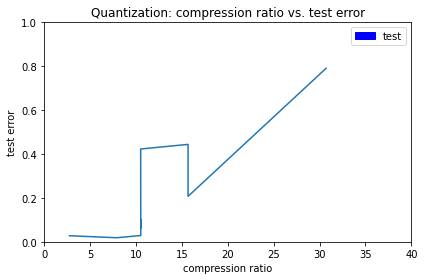

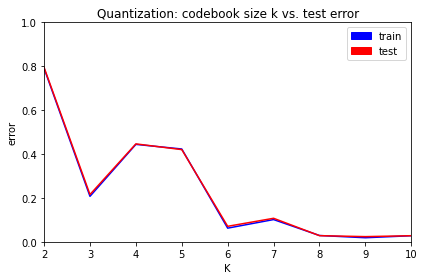

In [ ]:
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

# k = range(2,10)
quant_comp_ratio = pd.DataFrame([30.71, 15.68, 15.68,10.52,10.53,10.53,10.53,7.9,2.77])
quant_test_err = pd.DataFrame([79.07, 20.72, 44.40, 42.30, 6.22,10.13, 2.87, 1.85, 2.77])/100
quant_train_err = pd.DataFrame([79.46, 21.55, 44.63, 42.02, 7.06, 10.72, 2.80, 2.36, 2.78])/100
plt.figure(figsize = (6,4))
test_curve = plt.plot(quant_comp_ratio.to_numpy(), quant_test_err.to_numpy())
plt.xlim(0, 40)
plt.ylim(0, 1)
plt.xlabel("compression ratio")
plt.ylabel("test error")
plt.title("Quantization: compression ratio vs. test error")
plt.tight_layout()
blue_patch = mpatches.Patch(color='blue', label='test')
plt.legend(handles=[blue_patch])
plt.savefig('quant-comp-vs-error.png')
plt.show()

plt.figure(figsize = (6,4))
train_curve = plt.plot(range(2,11), quant_test_err.to_numpy(), 'b')
test_curve = plt.plot(range(2,11), quant_train_err.to_numpy(), 'r')
plt.xlim(2 , 10)
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("error")
plt.title("Quantization: codebook size k vs. test error")
plt.tight_layout()
red_patch = mpatches.Patch(color='red', label='test')
blue_patch = mpatches.Patch(color='blue', label='train')
plt.legend(handles=[blue_patch, red_patch])
plt.savefig('quant-k-vs-error.png')
plt.show()

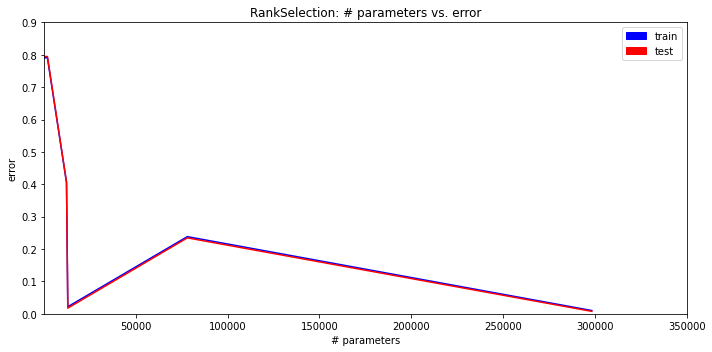

In [ ]:
rank_test_err = pd.DataFrame([79.46, 
                              79.46, 
                              40.72, 
                              1.75, 
                              23.45, 
                              0.75])/100
rank_train_err = pd.DataFrame([79.08, 
                               79.08, 
                               40.53, 
                               2.18, 
                               23.83, 
                               1.01])/100
rank_param = pd.DataFrame([90, 1875, 12265, 12965, 78050, 298275])

train_curve = plt.plot(rank_param.to_numpy(), rank_train_err.to_numpy(), 'b')
test_curve = plt.plot(rank_param.to_numpy(), rank_test_err.to_numpy(), 'r')

plt.xlim(50 , 350000)
plt.ylim(0, 0.9) 
plt.xlabel("# parameters")
plt.ylabel("error")
plt.title("RankSelection: # parameters vs. error")
plt.tight_layout()
red_patch = mpatches.Patch(color='red', label='test')
blue_patch = mpatches.Patch(color='blue', label='train')
plt.legend(handles=[blue_patch, red_patch])
plt.savefig('rank-param-vs-error.png')
plt.show()

# plt.figure(figsize = (6,4))
# rank_test_err = pd.DataFrame([79.46, 
#                               79.46, 
#                               40.72, 
#                               1.75, 
#                               23.45, 
#                               0.75])/100
# rank_train_err = pd.DataFrame([79.08, 
#                                79.08, 
#                                40.53, 
#                                2.18, 
#                                23.83, 
#                                1.01])/100
# rank_alpha = pd.DataFrame([1e-6, 1e-7, 1e-8, 5e-9, 1e-9, 1e-10])

# train_curve = plt.plot(rank_alpha.to_numpy(), rank_train_err.to_numpy(), 'b')
# test_curve = plt.plot(rank_alpha.to_numpy(), rank_test_err.to_numpy(), 'r')
# plt.xlim(0 , 1e-2)
# # plt.semilogx([10e-10, 10e-4])
# plt.ylim(0, 1) 
# plt.xlabel("# parameters")
# plt.ylabel("error")
# plt.title("RankSelection: alpha vs. error")
# plt.tight_layout()
# red_patch = mpatches.Patch(color='red', label='test')
# blue_patch = mpatches.Patch(color='blue', label='train')
# plt.legend(handles=[blue_patch, red_patch])
# plt.savefig('quant-alpha-vs-error.png')
# plt.show()